In [1]:
# Import libraries

# import numpy as np
# import pandas as pd
# import scipy as sp
# import matplotlib.pyplot as plt
# import seaborn as sns

import statsmodels.api as sm
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from patsy import dmatrix
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from scipy import stats
from statsmodels.graphics import utils
from statsmodels.stats.outliers_influence import variance_inflation_factor as vifval

# Import the functions used in this project
import my_functions as mf 

from datetime import datetime
from dateutil.parser import parse

# Pretty display for notebooks
%matplotlib inline


# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
train = pd.read_csv("asset/train.csv")
test = pd.read_csv("asset/test.csv")
weather = pd.read_csv("asset/weather.csv")
key = pd.read_csv("asset/key.csv")
submission = pd.read_csv("asset/sampleSubmission.csv")

import pickle as pkl

# Success - Display the first record
print("Train data : ", train.shape)
print("Test  data : ", test.shape)
print("weather  data : ", weather.shape)
print("key  data : ", key.shape)
print("submission  data : ", submission.shape)

# 원본을 유지하기 위해서 카피
df_train = train.copy()
df_test = test.copy()
df_weather = weather.copy()
df_key = key.copy()
df_submission = submission.copy()

Train data :  (4617600, 4)
Test  data :  (526917, 3)
weather  data :  (20517, 20)
key  data :  (45, 2)
submission  data :  (526917, 2)


In [2]:
df = pkl.load(open("preprocess_date.pkl", "rb"))

In [3]:
model_1 = pd.DataFrame(dmatrix("C(store_nbr):C(item_nbr) + 0", data=df))

In [4]:
def getFormula(df, categorical_columns, target_column):
    """
        df : 회귀분석할 df
        categorical_columns : 카테고리 컬럼명 리스트
        target_column : target column명 문자열
    """
    columns = df.columns
    formula = target_column + " ~ "
    for i, column in enumerate(columns):
        if column != target_column:
            if i != 0:
                formula += " + "
            if column in categorical_columns:
                formula += "C(" + column + ")"
            else:
                formula += str(column)
    return formula

In [5]:
from patsy import ContrastMatrix

In [11]:
def getColumnsNotZeros(df):
    count = 0
    li = []
    for column in df.columns:
        sum_of_data_by_column = df[column].sum()
        if sum_of_data_by_column == 0:
            count += 1
        else:
            li.append(column)
    print("0으로만 이루어진 컬럼 수 : " + str(count)) 
    print("0이 아닌 컬럼 수 : " + str(len(li)))
    return li

In [7]:
def setModelDf(df, li):
    return df[li]

In [8]:
def getOlsResult(df, target):
    model = sm.OLS(target, df)
    result = model.fit()
    print(result.summary())
    return result

In [9]:
def drawTargetAndPredictedScatterPlot(result, df, target, is_transform_to_units = False):
    predictions = result.predict(df)
    if is_transform_to_units:
        predictions = np.exp(predictions)
        target = np.exp(target)
    plt.scatter(target, predictions)
    plt.xlabel(u"실제값")
    plt.ylabel(u"예측치")
    plt.show()

In [12]:
li_1 = getColumnsNotZeros(model_1)

0으로만 이루어진 컬럼 수 : 4740
0이 아닌 컬럼 수 : 255


In [13]:
model_1 = setModelDf(model_1, li_1)

In [15]:
result = getOlsResult(model_1, df["log1p"])

                            OLS Regression Results                            
Dep. Variable:                  log1p   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     7158.
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        15:05:40   Log-Likelihood:            -2.1261e+05
No. Observations:              236038   AIC:                         4.257e+05
Df Residuals:                  235783   BIC:                         4.284e+05
Df Model:                         254                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
35             0.3676      0.019     19.154      0.0

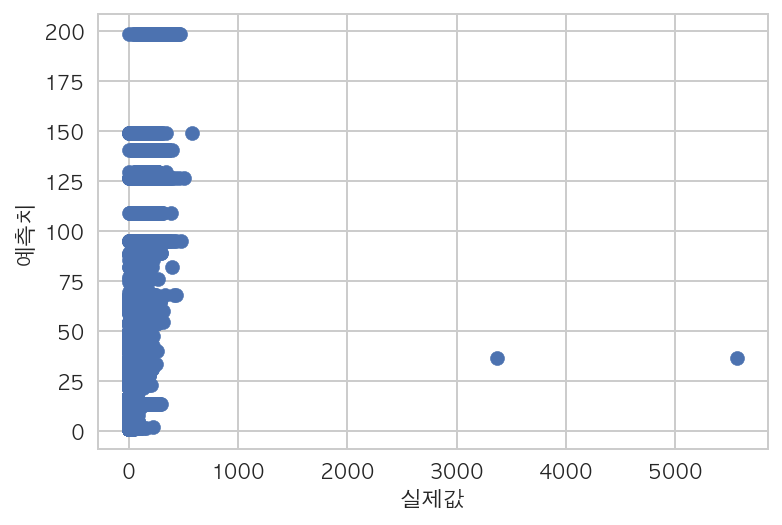

In [16]:
drawTargetAndPredictedScatterPlot(result, model_1, df["log1p"], True)

### 컬럼의 의미: 한 스토어당 111개의 아이템을 바라보게 되므로 원래는 111 * 45인 4995개의 컬럼이 만들어지지만,
### 스토어별로 팔린아이템넘버와 interaction된 컬럼만 남게되므로 총 255개가 남는다.
### 35번의 의미는 1번 스토어의 36번 아이템을 의미한다.

## 아래의 셀에서 확인가능한 사실은 C(store_nbr):C(item_nbr) 로 나온 가중치의 의미는
## 팔린 총 개수 / 우리가 팔았다고 기록된 날(day)의 수

In [23]:
sum(model_1[35])

964.0

In [17]:
df[(df["store_nbr"] == 36) & (df["item_nbr"] == 1)]["log1p"].sum()/964

0.36762786964021665

In [27]:
month_contrast = ContrastMatrix(np.eye(12), range(1, 13))

In [28]:
df.columns

Index(['date', 'store_nbr', 'item_nbr', 'units', 'log1p', 'date2',
       'station_nbr', 'preciptotal_flag', 'depart_flag', 'weekday',
       'is_weekend', 'is_holiday', 'is_holiday_weekday', 'is_holiday_weekend',
       'day', 'month', 'year', 'holiday_name', 'around_BlackFriday'],
      dtype='object')

In [29]:
model_2 = pd.DataFrame(dmatrix("C(month, month_contrast):C(item_nbr) + C(store_nbr):C(item_nbr) + 0", data=df))

In [31]:
li_2 = getColumnsNotZeros(model_2)

0으로만 이루어진 컬럼 수 : 4637
0이 아닌 컬럼 수 : 1579


In [32]:
model_2 = setModelDf(model_2, li_2)

In [34]:
result = getOlsResult(model_2, df["log1p"])

                            OLS Regression Results                            
Dep. Variable:                  log1p   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     1339.
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        18:33:47   Log-Likelihood:            -2.0335e+05
No. Observations:              236038   AIC:                         4.097e+05
Df Residuals:                  234562   BIC:                         4.250e+05
Df Model:                        1475                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0           7.222e+10   1.09e+11      0.664      0.5